In [2]:
from karabo.simulation.signal.plotting import SignalPlotting, SegmentationPlotting
from karabo.simulation.signal.signal_21_cm import Signal21cm
from karabo.simulation.signal.synchroton_signal import SynchrotonSignal
from karabo.simulation.signal.galactic_foreground import SignalGalacticForeground
from karabo.simulation.signal.superimpose import Superimpose
from karabo.simulation.signal.superpixel_segmentation import SuperpixelSegmentation
from karabo.simulation.signal.seg_u_net_segmentation import SegUNetSegmentation

from astropy.coordinates import Angle, SkyCoord
from astropy import units
from karabo.simulation.signal.typing import Image2D, Image3D

2023-05-12 12:36:54.464351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
print(SignalGalacticForeground.available_redshifts())
print("- " * 3)
print(Signal21cm.available_redshifts())

[7.6, 8.4, 9.2, 9.9, 10.7, 11.5, 12.2, 13.0, 14.3, 15.1, 15.8, 16.6, 17.4, 18.1, 18.9, 19.7, 20.4, 21.2, 22.0, 22.7]
- - - 
[6.0, 6.056, 6.113, 6.172, 6.231, 6.292, 6.354, 6.418, 6.483, 6.549, 6.617, 6.686, 6.757, 6.83, 6.905, 6.981, 7.059, 7.139, 7.221, 7.305, 7.391, 7.48, 7.57, 7.664, 7.76, 7.859, 7.96, 8.064, 8.172, 8.283, 8.397, 8.515, 8.636, 8.762, 8.892, 9.026, 9.164, 9.308, 9.457, 9.611, 9.771, 9.938, 10.11, 10.29, 10.478, 10.673, 10.877, 11.09, 11.313, 11.546, 11.791, 12.048, 12.318, 12.603, 12.903, 13.221, 13.557, 13.914, 14.294, 14.699, 15.132, 15.596, 16.095, 16.633, 17.215, 17.848, 18.54, 19.298, 20.134]


**7.6** lower:7.57 (0.03) higher:7.664 (0.064)  
**8.4** lower:8.397 (0.003) higher:8.515 (0.115)  
**9.2** lower:9.164 (0.036) higher:9.308 (0.108)  
**9.9** lower:9.771 (0.129) higher:9.938 (0.038)

**10.7** lower:10.673 (0.027) higher:10.877 (0.177)  
**11.5** lower:11.313 (0.187) higher:11.546 (0.046)  
**12.2** lower:12.048 (0.152) higher:12.318 (0.118)  
**13.0** lower:12.903 (0.097) higher:13.221 (0.221)

**14.3** lower:14.294 (0.006) higher:14.699 (0.399)  
**15.1** lower:14.699 (0.401) higher:15.132 (0.032)  
**15.8** lower:15.596 (0.204) higher:16.095 (0.295)  
**16.6** lower:16.095 (0.505) higher:16.633 (0.033)

**17.4** lower:17.215 (0.185) higher:17.848 (0.448)  
**18.1** lower:17.848 (0.252) higher:18.54 (0.44)  
**18.9** lower:18.54 (0.36) higher:19.298 (0.398)  
**19.7** lower:19.298 (0.402) higher:20.134 (0.434)

**20.4** lower:20.134 (0.266) higher: -  
**21.2** lower: - higher: -  
**22.0** lower: - higher: -  
**22** lower: - higher: -


**7.6** lower:7.57 (0.03)  
**8.4 lower:8.397 (0.003)**  
**9.2** lower:9.164 (0.036)  
**9.9** higher:9.938 (0.038)

**10.7 lower:10.673 (0.027)**  
**11.5** higher:11.546 (0.046)  
**13.0** lower:12.903 (0.097)

**14.3 lower:14.294 (0.006)**  
**15.1** higher:15.132 (0.032)  
**16.6** higher:16.633 (0.033)

**17.4 lower:17.215 (0.185)**  
**18.1** lower:17.848 (0.252)  
**18.9** lower:18.54 (0.36)

**20.4 lower:20.134 (0.266)**


In [8]:
# (Galactic, Signal21)
redshift_sig21 = [
    8.397,
    # 10.673,
    # 14.294,
    # 17.215,
    # 20.134,
]
redshift_gf = [
    8.4,
    # 10.7,
    # 14.3,
    # 17.4,
    # 20.4,
]

In [11]:
from karabo.simulation.signal.base_signal import BaseSignal
from karabo.simulation.signal.typing import BaseImage


class ZPipeline:
    def __init__(self, redshifts_sig21: list[float], redshifts_galactic: list[float]) -> None:
        self.redshifts_sig21 = redshifts_sig21
        self.redshifts_galactic = redshifts_galactic

        # prepare signal21cm
        files_sig21 = [Signal21cm.get_xfrac_dens_file(
            z=z, box_dims=244 / 0.7) for z in redshifts_sig21]
        self.signal_21 = Signal21cm(files_sig21)
        grid_size = (250, 250)

        # prepare galactic foreground
        cent = SkyCoord(ra=10 * units.degree, dec=20 * units.degree, frame="icrs")
        fov = Angle([20, 20], unit=units.degree)
        self.gf = SignalGalacticForeground(
            cent,
            redshifts=redshifts_galactic,
            fov=fov,
            grid_size=grid_size,
        )

        # prepare synchroton
        self.sync = SynchrotonSignal(
            centre=cent,
            fov=fov,
            grid_size=grid_size,
        )

    def run(self) -> list[BaseImage]:

        image_sync = self.sync.simulate()[0]
        images_sig21 = self.signal_21.simulate()
        images_galactic = self.gf.simulate()

        images = []
        for im_21, im_gal in zip(images_sig21, images_galactic):
            image = Superimpose.combine(im_21, im_gal, image_sync)
            images.append(image)

        res = []
        for image in images:
            superpixel_image = SuperpixelSegmentation().segment(image)
            _ = SegmentationPlotting.superpixel_plotting(
                superpixel_image, self.signal_21)

            seg_u_net_image = SegUNetSegmentation(tta=0).segment(image)
            _ = SegmentationPlotting.seg_u_net_plotting(seg_u_net_image)

            res.append((superpixel_image, seg_u_net_image))

        return res


images = ZPipeline(redshifts_sig21=redshift_sig21, redshifts_galactic=redshift_gf).run()

100%|██████████| 250/250 [00:00<00:00, 426.48it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 1000 segments
Estimating the superpixel mean map...


100%|██████████| 1000/1000 [00:00<00:00, 37545.02it/s]


...done
Constructing the superpixel map...


100%|██████████| 1000/1000 [00:19<00:00, 52.12it/s]


Estimating the superpixel mean map...


100%|██████████| 1000/1000 [00:00<00:00, 32380.70it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 400.66it/s]


AttributeError: 'Signal21cm' object has no attribute 'data'

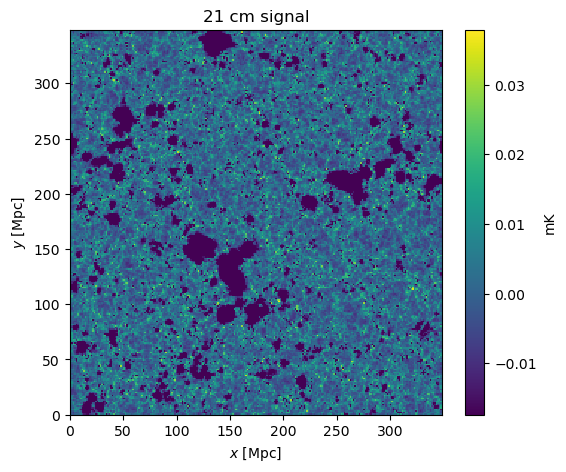

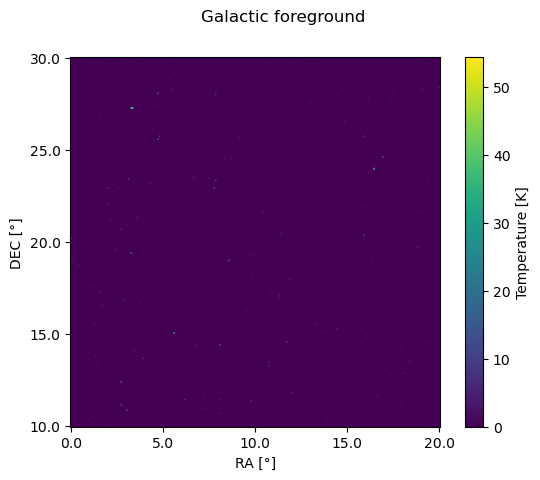

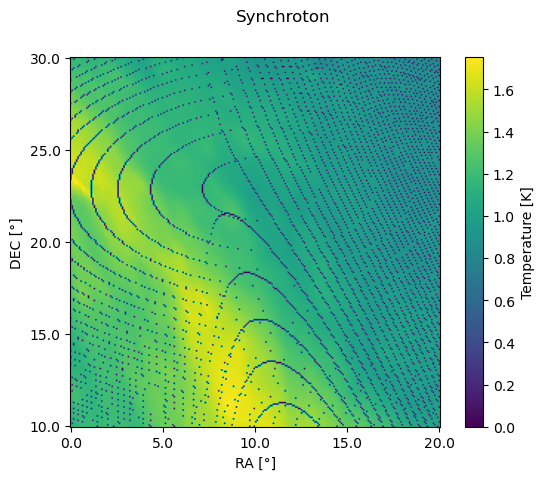

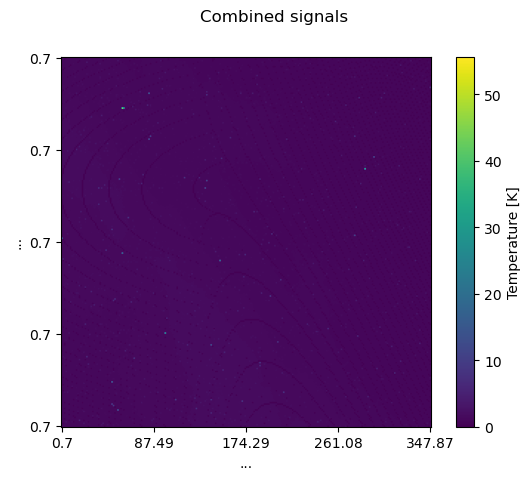

In [20]:
_ = SignalPlotting.brightness_temperature(sig_21)
_ = SignalPlotting.general_img(gf_sim, "Galactic foreground")  # TODO
_ = SignalPlotting.general_img(sync_sim, "Synchroton")

out_img = Image2D(
    data=out.data[0, :, :],
    x_label=out.x_label[0, 0, :],
    y_label=out.y_label[0, 0, :],
    redshift=out.redshift,
    box_dims=out.box_dims,
)
_ = SignalPlotting.general_img(
    out_img, "Combined signals", x_label="...", y_label="..."
)